## Load Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
from decay_functions import *
from helper_functions import *
from cov_estimators import *
from backtest_functions import *
from optimizers import *

In [3]:
sp500 = get_sp500_adjusted_close('2010-01-01', '2025-04-14')
sp500.index=pd.to_datetime(sp500.index)
sp500=sp500.pct_change().iloc[1:,:]
sp500.head()

Loading cached data from data/sp500_adjclose_2010-01-01_to_2025-04-14.csv


,MMM,AOS,ABT,ABBV,ACN,ADBE,AMD,AES,AFL,A,APD,ABNB,AKAM,ALB,ARE,ALGN,ALLE,LNT,ALL,GOOGL,GOOG,MO,AMZN,AMCR,AEE,AEP,AXP,AIG,AMT,AWK,AMP,AME,AMGN,APH,ADI,ANSS,AON,APA,APO,AAPL,...,UNH,UHS,VLO,VTR,VLTO,VRSN,VRSK,VZ,VRTX,VTRS,VICI,V,VST,VMC,WRB,GWW,WAB,WBA,WMT,DIS,WBD,WM,WAT,WEC,WFC,WELL,WST,WDC,WY,WSM,WMB,WTW,WDAY,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZTS
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-05,-0.006263,-0.012777,-0.008080,NaN,0.006180,0.016446,0.001031,-0.010242,0.029010,-0.010863,-0.008297,NaN,0.029707,-0.001838,-0.010543,-0.026486,NaN,0.023394,0.016442,-0.004404,-0.004404,0.000505,0.005900,NaN,-0.003963,-0.011448,-0.002199,-0.018735,0.016567,0.010154,0.023320,-0.004404,-0.008662,-0.020897,-0.001579,-0.022401,-0.006326,0.011807,NaN,0.001729,...,-0.001586,-0.008026,0.025713,0.004844,NaN,0.010509,0.006700,0.001803,-0.033002,-0.010684,NaN,-0.011459,NaN,0.003793,-0.003672,0.000411,0.000240,-0.008043,-0.009957,-0.002495,0.039355,-0.004391,-0.013630,-0.013070,0.027453,0.014078,-0.012668,0.026513,0.021229,0.027845,0.012495,-0.002241,NaN,0.060820,-0.011859,NaN,-0.003420,-0.001744,0.031656,NaN
2010-01-06,0.014181,0.000454,0.005554,NaN,0.010631,-0.002122,-0.014418,-0.010347,0.008784,-0.003553,-0.008245,NaN,-0.008243,0.001841,-0.005248,-0.029428,NaN,0.007726,0.000324,-0.025209,-0.025209,0.014646,-0.018116,NaN,-0.006872,0.010133,0.016164,-0.006478,0.005206,0.005245,0.013967,0.001041,-0.007515,0.003780,-0.001897,-0.006645,-0.000265,0.015684,NaN,-0.015906,...,0.009848,-0.004854,0.025068,-0.011249,NaN,-0.010800,0.012978,-0.028754,-0.017532,-0.009719,NaN,-0.013428,NaN,0.017382,0.002048,0.003803,0.006230,-0.007567,-0.002235,-0.005314,0.014898,-0.000294,0.001810,0.010187,0.001425,-0.004926,-0.009751,0.000861,-0.011057,0.035497,0.032449,0.016098,NaN,-0.013117,0.001920,NaN,-0.007149,-0.007687,-0.000323,NaN
2010-01-07,0.000718,0.002951,0.008284,NaN,-0.000935,-0.019405,-0.010449,0.000747,0.010733,-0.001297,-0.005747,NaN,0.000378,-0.007088,0.009273,-0.002860,NaN,0.005432,0.005174,-0.023280,-0.023279,-0.001493,-0.017013,NaN,-0.009468,0.008599,0.016219,-0.019218,-0.002702,0.002174,0.007491,0.002599,-0.009157,-0.006644,-0.007922,0.002537,-0.002919,-0.015165,NaN,-0.001849,...,0.038377,0.014959,0.007443,0.011145,NaN,-0.013748,-0.001643,-0.005952,-0.012610,-0.016903,NaN,0.009306,NaN,-0.012628,0.004087,0.009422,0.000953,0.005991,0.000560,0.000314,-0.000612,0.002353,0.004269,-0.002017,0.036286,0.002025,0.003109,-0.019570,-0.004472,0.047813,-0.007083,-0.002948,NaN,0.021356,-0.004312,NaN,-0.000288,-0.025000,0.022940,NaN
2010-01-08,0.007046,0.014709,0.005112,NaN,-0.003978,-0.005422,-0.004224,0.028358,-0.010018,-0.000325,0.006395,NaN,0.000000,0.015071,-0.003327,0.013196,NaN,0.019384,0.004183,0.013331,0.013331,0.002493,0.027077,NaN,-0.006985,0.011936,-0.000715,0.026593,0.002032,-0.002169,0.003598,0.019445,0.008886,0.007357,0.005749,0.006903,0.008249,-0.005226,NaN,0.006648,...,-0.009391,0.045178,-0.013720,-0.011022,NaN,0.007790,-0.012833,0.000631,-0.020000,-0.033833,NaN,0.002767,NaN,-0.009780,-0.000814,0.011768,0.016179,0.001354,-0.005037,0.001571,0.003060,0.004695,0.000818,0.005861,-0.009269,-0.010330,-0.000258,0.005045,-0.009209,-0.015497,0.008025,-0.001109,NaN,-0.007165,0.000482,NaN,0.000288,-0.003250,-0.021004,NaN
2010-01-11,-0.004032,-0.004683,0.005086,NaN,-0.000939,-0.013083,-0.030753,0.006531,0.026311,0.000650,0.018328,NaN,-0.003399,-0.004428,0.005245,-0.006795,NaN,-0.002182,0.000000,-0.001512,-0.001512,0.007459,-0.024041,NaN,0.008145,0.010390,-0.011443,0.009884,-0.009013,0.010000,0.012906,0.005850,0.004404,0.002435,-0.005716,0.003885,0.004223,0.003002,NaN,-0.008821,...,0.006728,-0.010423,-0.009631,0.020200,NaN,-0.002848,-0.002333,0.004094,0.028522,0.020092,NaN,-0.002874,NaN,-0.008927,0.002037,0.004211,-0.009599,0.001622,0.016501,-0.016311,-0.003356,0.012558,0.019931,0.014869,-0.002079,0.002269,-0.004393,0.001091,0.006574,-0.008746,-0.006192,0.009989,NaN,-0.003240,0.009619,NaN,0.017281,0.003261,0.022100,NaN


Text(0.5, 1.0, 'null value distribution')

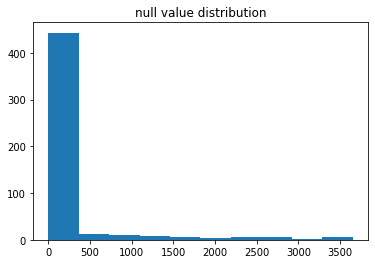

In [4]:
plt.hist(sp500.isna().sum(axis=0))
plt.title("null value distribution")


In [5]:

# most stocks have complete data, directly drop incomplete stocks for convenience
sp500=sp500.dropna(axis=1)
sp500

,MMM,AOS,ABT,ACN,ADBE,AMD,AES,AFL,A,APD,AKAM,ALB,ARE,ALGN,LNT,ALL,GOOGL,GOOG,MO,AMZN,AEE,AEP,AXP,AIG,AMT,AWK,AMP,AME,AMGN,APH,ADI,ANSS,AON,APA,AAPL,AMAT,ACGL,ADM,AJG,AIZ,...,UDR,ULTA,UNP,UAL,UPS,URI,UNH,UHS,VLO,VTR,VRSN,VRSK,VZ,VRTX,VTRS,V,VMC,WRB,GWW,WAB,WBA,WMT,DIS,WBD,WM,WAT,WEC,WFC,WELL,WST,WDC,WY,WSM,WMB,WTW,WYNN,XEL,YUM,ZBRA,ZBH
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-05,-0.006263,-0.012777,-0.008080,0.006180,0.016446,0.001031,-0.010242,0.029010,-0.010863,-0.008297,0.029707,-0.001838,-0.010543,-0.026486,0.023394,0.016442,-0.004404,-0.004404,0.000505,0.005900,-0.003963,-0.011448,-0.002199,-0.018735,0.016567,0.010154,0.023320,-0.004404,-0.008662,-0.020897,-0.001579,-0.022401,-0.006326,0.011807,0.001729,-0.007693,-0.003336,0.005402,-0.005374,0.029841,...,-0.001234,-0.004775,0.013916,0.086719,0.001719,-0.010956,-0.001586,-0.008026,0.025713,0.004844,0.010509,0.006700,0.001803,-0.033002,-0.010684,-0.011459,0.003793,-0.003672,0.000411,0.000240,-0.008043,-0.009957,-0.002495,0.039355,-0.004391,-0.013630,-0.013070,0.027453,0.014078,-0.012668,0.026513,0.021229,0.027845,0.012495,-0.002241,0.060820,-0.011859,-0.003420,-0.001744,0.031656
2010-01-06,0.014181,0.000454,0.005554,0.010631,-0.002122,-0.014418,-0.010347,0.008784,-0.003553,-0.008245,-0.008243,0.001841,-0.005248,-0.029428,0.007726,0.000324,-0.025209,-0.025209,0.014646,-0.018116,-0.006872,0.010133,0.016164,-0.006478,0.005206,0.005245,0.013967,0.001041,-0.007515,0.003780,-0.001897,-0.006645,-0.000265,0.015684,-0.015906,-0.002114,-0.004323,-0.002529,0.000450,-0.002898,...,-0.006795,0.024520,0.001508,-0.046010,-0.007378,0.000000,0.009848,-0.004854,0.025068,-0.011249,-0.010800,0.012978,-0.028754,-0.017532,-0.009719,-0.013428,0.017382,0.002048,0.003803,0.006230,-0.007567,-0.002235,-0.005314,0.014898,-0.000294,0.001810,0.010187,0.001425,-0.004926,-0.009751,0.000861,-0.011057,0.035497,0.032449,0.016098,-0.013117,0.001920,-0.007149,-0.007687,-0.000323
2010-01-07,0.000718,0.002951,0.008284,-0.000935,-0.019405,-0.010449,0.000747,0.010733,-0.001297,-0.005747,0.000378,-0.007088,0.009273,-0.002860,0.005432,0.005174,-0.023280,-0.023279,-0.001493,-0.017013,-0.009468,0.008599,0.016219,-0.019218,-0.002702,0.002174,0.007491,0.002599,-0.009157,-0.006644,-0.007922,0.002537,-0.002919,-0.015165,-0.001849,-0.010593,-0.005882,-0.010456,-0.006300,0.012270,...,0.007463,0.085328,-0.008886,0.021100,-0.007606,-0.013092,0.038377,0.014959,0.007443,0.011145,-0.013748,-0.001643,-0.005952,-0.012610,-0.016903,0.009306,-0.012628,0.004087,0.009422,0.000953,0.005991,0.000560,0.000314,-0.000612,0.002353,0.004269,-0.002017,0.036286,0.002025,0.003109,-0.019570,-0.004472,0.047813,-0.007083,-0.002948,0.021356,-0.004312,-0.000288,-0.025000,0.022940
2010-01-08,0.007046,0.014709,0.005112,-0.003978,-0.005422,-0.004224,0.028358,-0.010018,-0.000325,0.006395,0.000000,0.015071,-0.003327,0.013196,0.019384,0.004183,0.013331,0.013331,0.002493,0.027077,-0.006985,0.011936,-0.000715,0.026593,0.002032,-0.002169,0.003598,0.019445,0.008886,0.007357,0.005749,0.006903,0.008249,-0.005226,0.006648,0.038544,-0.001972,-0.012488,0.002718,0.000638,...,-0.019753,0.035954,0.033885,-0.016236,0.048075,-0.022449,-0.009391,0.045178,-0.013720,-0.011022,0.007790,-0.012833,0.000631,-0.020000,-0.033833,0.002767,-0.009780,-0.000814,0.011768,0.016179,0.001354,-0.005037,0.001571,0.003060,0.004695,0.000818,0.005861,-0.009269,-0.010330,-0.000258,0.005045,-0.009209,-0.015497,0.008025,-0.001109,-0.007165,0.000482,0.000288,-0.003250,-0.021004
2010-01-11,-0.004032,-0.004683,0.005086,-0.000939,-0.013083,-0.030753,0.006531,0.026311,0.000650,0.018328,-0.003399,-0.004428,0.005245,-0.006795,-0.002182,0.000000,-0.001512,-0.001512,0.007459,-0.024041,0.008145,0.010390,-0.011443,0.009884,-0.009013,0.010000,0.012906,0.005850,0.004404,0.002435,-0.005716,0.003885,0.004223,0.003002,-0.008821,0.021993,-0.003106,0.000649,0.001355,0.007014,...,0.006926,-0.015271,-0.006613,-0.016504,0.044041,-0.029227,0.006728,-0.010423,-0.009

## Decay Functions Visualization

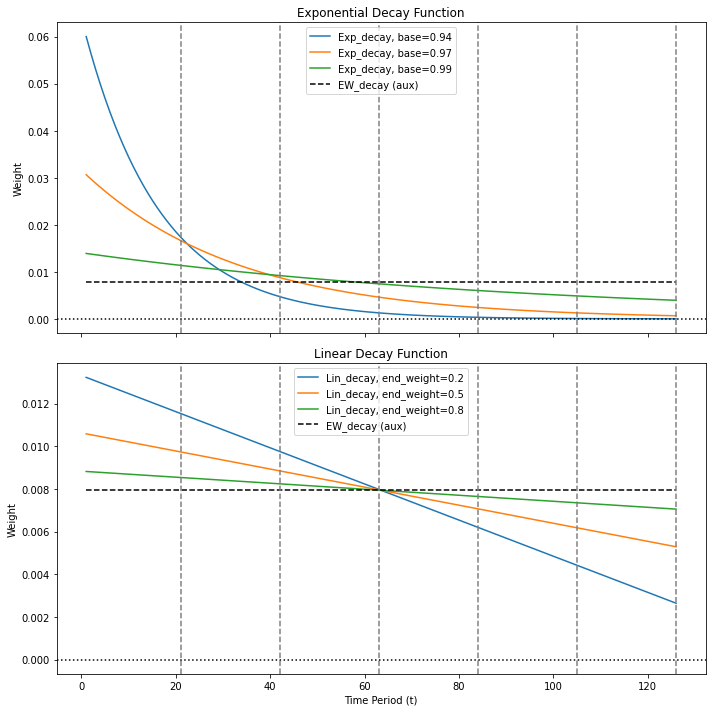

In [6]:
# Set the look-back window (T) so that key points are within the range.
T = 126
t_vals = np.arange(1, T + 1)
dash_positions = np.array([21, 42, 63, 84, 105, 126])
# Compute equal weights using EW_decay (to be used as an auxiliary line).
ew = EW_decay(T)

# Create a figure with 2 subplots: one for Exp_decay and one for Lin_decay.
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), sharex=True)

# -------------------- Plot for Exp_decay --------------------
ax = axs[0]
# Choose several representative base parameters.
bases = [0.94, 0.97, 0.99]
for base in bases:
    weights_exp = Exp_decay(T, base)
    ax.plot(t_vals, weights_exp, label=f"Exp_decay, base={base}")
# Plot EW decay as an auxiliary line.
ax.plot(t_vals, ew, 'k--', label="EW_decay (aux)")
# Draw vertical dashed lines at the key t positions.
for pos in dash_positions:
    ax.axvline(x=pos, linestyle='--', color='gray')
# Add a horizontal dashed line at y=0.
ax.axhline(y=0, color='black', linestyle=':')
ax.set_title("Exponential Decay Function")
ax.set_ylabel("Weight")
ax.legend()

# -------------------- Plot for Lin_decay --------------------
ax = axs[1]
# Choose several representative end_weight parameters.
end_weights = [0.2, 0.5, 0.8]
for end_weight in end_weights:
    weights_lin = Lin_decay(T, end_weight)
    ax.plot(t_vals, weights_lin, label=f"Lin_decay, end_weight={end_weight}")
# Plot EW decay as an auxiliary line.
ax.plot(t_vals, ew, 'k--', label="EW_decay (aux)")
# Draw vertical dashed lines at the key t positions.
for pos in dash_positions:
    ax.axvline(x=pos, linestyle='--', color='gray')
# Add a horizontal dashed line at y=0.
ax.axhline(y=0, color='black', linestyle=':')
ax.set_title("Linear Decay Function")
ax.set_xlabel("Time Period (t)")
ax.set_ylabel("Weight")
ax.legend()

plt.tight_layout()
plt.show()

## Backtest

### Backtest Parameters

In [7]:
stock_sublist=['CVX', 'CMCSA', 'XOM', 'IBM', 'PAYX', 'AKAM', 'ZBH', 'JBHT', 'BEN', 'WST', 'FDX', 'EOG', 'WSM', 'CINF', 'ECL']
# stock sublist (randomly selected from sp500) for low dimensional experiment.

sp500_train=sp500.iloc[:252*3,:]
sp500_train_lowdim=sp500_train[stock_sublist]

In [8]:
# Look-back windows
lbw_list = [21, 21*3, 21*6]  # [21, 63, 126]

# Exp_decay base parameters
exp_bases = [0.99, 0.97, 0.94]
exp_bases = [0.99, 0.97]

# Lin_decay end_weight parameters
lin_endweights = [0.2, 0.5, 0.8]

# LedoitWolf alpha parameters
lw_alphas = [0.2, 0.4, 0.6]

gerber_cs = [0.3, 0.5, 0.7]



In [9]:
decay_settings = {
    "EW": {"func": EW_decay, "params": ["no param"]},
    "Exp": {"func": Exp_decay, "params": exp_bases},
    "Lin": {"func": Lin_decay, "params": lin_endweights},
}

cov_settings = {
    "SCM": {"func": SCM, "params": ["no param"]},
    "LedoitWolf": {"func": LedoitWolf, "params": lw_alphas},
    "GerberCov": {"func": GerberCov, "params": gerber_cs}
}



### Backtest With analytical solution ($\Sigma^{-1}$)

In [10]:

min_var_opt_inv_var_df, min_var_opt_inv_returns_cache, min_var_opt_inv_weights_cache = run_backtests(
    ret_data=sp500_train,
    optimizer=min_var_opt_inv,
    lbw_list=lbw_list,
    decay_settings=decay_settings,
    cov_settings=cov_settings,
    var_cache_file="backtest_vars_cache.pkl",
    returns_cache_file="backtest_returns_cache.pkl",
    weights_cache_file="backtest_weights_cache.pkl",
)



[Cached] (21, 'EW', 'no param', 'SCM', 'no param')
Progress: 1/126 (0.8%)
[Cached] (21, 'Exp', '0.99', 'SCM', 'no param')
Progress: 2/126 (1.6%)
[Cached] (21, 'Exp', '0.97', 'SCM', 'no param')
Progress: 3/126 (2.4%)
[Cached] (21, 'Lin', '0.2', 'SCM', 'no param')
Progress: 4/126 (3.2%)
[Cached] (21, 'Lin', '0.5', 'SCM', 'no param')
Progress: 5/126 (4.0%)
[Cached] (21, 'Lin', '0.8', 'SCM', 'no param')
Progress: 6/126 (4.8%)
[Cached] (21, 'EW', 'no param', 'LedoitWolf', '0.2')
Progress: 7/126 (5.6%)
[Cached] (21, 'Exp', '0.99', 'LedoitWolf', '0.2')
Progress: 8/126 (6.3%)
[Cached] (21, 'Exp', '0.97', 'LedoitWolf', '0.2')
Progress: 9/126 (7.1%)
[Cached] (21, 'Lin', '0.2', 'LedoitWolf', '0.2')
Progress: 10/126 (7.9%)
[Cached] (21, 'Lin', '0.5', 'LedoitWolf', '0.2')
Progress: 11/126 (8.7%)
[Cached] (21, 'Lin', '0.8', 'LedoitWolf', '0.2')
Progress: 12/126 (9.5%)
[Cached] (21, 'EW', 'no param', 'LedoitWolf', '0.4')
Progress: 13/126 (10.3%)
[Cached] (21, 'Exp', '0.99', 'LedoitWolf', '0.4')
Progr

### Backtest With analytical solution (Stablized)

#### Full Sample

In [11]:
stable_fullsample_analytical_var_df, stable_fullsample_analytical_returns_cache, stable_fullsample_analytical_weights_cache = run_backtests(
    ret_data=sp500_train,
    optimizer=min_var_opt_stable,
    lbw_list=lbw_list,
    decay_settings=decay_settings,
    cov_settings=cov_settings,
    var_cache_file="backtest_FullSample_StableOptimizer_vars_cache.pkl",
    returns_cache_file="backtest_FullSample_StableOptimizer_returns_cache.pkl",
    weights_cache_file="backtest_FullSample_StableOptimizer_weights_cache.pkl",
)



[Cached] (21, 'EW', 'no param', 'SCM', 'no param')
Progress: 1/126 (0.8%)
[Cached] (21, 'Exp', '0.99', 'SCM', 'no param')
Progress: 2/126 (1.6%)
[Cached] (21, 'Exp', '0.97', 'SCM', 'no param')
Progress: 3/126 (2.4%)
[Cached] (21, 'Lin', '0.2', 'SCM', 'no param')
Progress: 4/126 (3.2%)
[Cached] (21, 'Lin', '0.5', 'SCM', 'no param')
Progress: 5/126 (4.0%)
[Cached] (21, 'Lin', '0.8', 'SCM', 'no param')
Progress: 6/126 (4.8%)
[Cached] (21, 'EW', 'no param', 'LedoitWolf', '0.2')
Progress: 7/126 (5.6%)
[Cached] (21, 'Exp', '0.99', 'LedoitWolf', '0.2')
Progress: 8/126 (6.3%)
[Cached] (21, 'Exp', '0.97', 'LedoitWolf', '0.2')
Progress: 9/126 (7.1%)
[Cached] (21, 'Lin', '0.2', 'LedoitWolf', '0.2')
Progress: 10/126 (7.9%)
[Cached] (21, 'Lin', '0.5', 'LedoitWolf', '0.2')
Progress: 11/126 (8.7%)
[Cached] (21, 'Lin', '0.8', 'LedoitWolf', '0.2')
Progress: 12/126 (9.5%)
[Cached] (21, 'EW', 'no param', 'LedoitWolf', '0.4')
Progress: 13/126 (10.3%)
[Cached] (21, 'Exp', '0.99', 'LedoitWolf', '0.4')
Progr

#### Reduced Sample

In [12]:

stable_reducedsample_analytical_var_df, stable_reducedsample_analytical_returns_cache, stable_reducedsample_analytical_weights_cache = run_backtests(
    ret_data=sp500_train,
    optimizer=min_var_opt_stable,
    lbw_list=lbw_list,
    decay_settings=decay_settings,
    cov_settings=cov_settings,
    var_cache_file="backtest_ReducedSample_StableOptimizer_vars_cache.pkl",
    returns_cache_file="backtest_ReducedSample_StableOptimizer_returns_cache.pkl",
    weights_cache_file="backtest_ReducedSample_StableOptimizer_weights_cache.pkl",
)



[Cached] (21, 'EW', 'no param', 'SCM', 'no param')
Progress: 1/126 (0.8%)
[Cached] (21, 'Exp', '0.99', 'SCM', 'no param')
Progress: 2/126 (1.6%)
[Cached] (21, 'Exp', '0.97', 'SCM', 'no param')
Progress: 3/126 (2.4%)
[Cached] (21, 'Lin', '0.2', 'SCM', 'no param')
Progress: 4/126 (3.2%)
[Cached] (21, 'Lin', '0.5', 'SCM', 'no param')
Progress: 5/126 (4.0%)
[Cached] (21, 'Lin', '0.8', 'SCM', 'no param')
Progress: 6/126 (4.8%)
[Cached] (21, 'EW', 'no param', 'LedoitWolf', '0.2')
Progress: 7/126 (5.6%)
[Cached] (21, 'Exp', '0.99', 'LedoitWolf', '0.2')
Progress: 8/126 (6.3%)
[Cached] (21, 'Exp', '0.97', 'LedoitWolf', '0.2')
Progress: 9/126 (7.1%)
[Cached] (21, 'Lin', '0.2', 'LedoitWolf', '0.2')
Progress: 10/126 (7.9%)
[Cached] (21, 'Lin', '0.5', 'LedoitWolf', '0.2')
Progress: 11/126 (8.7%)
[Cached] (21, 'Lin', '0.8', 'LedoitWolf', '0.2')
Progress: 12/126 (9.5%)
[Cached] (21, 'EW', 'no param', 'LedoitWolf', '0.4')
Progress: 13/126 (10.3%)
[Cached] (21, 'Exp', '0.99', 'LedoitWolf', '0.4')
Progr

## Results

### Compare inv solver and stablized solver

In [13]:
stable_fullsample_analytical_var_df.sort_values(by='strategy_variance')

,lbw,decay_function,decay_parameter,cov_estimator,cov_param,strategy_variance
19,21,Exp,0.99,LedoitWolf,0.6,0.036634
13,21,Exp,0.99,LedoitWolf,0.4,0.036634
7,21,Exp,0.99,LedoitWolf,0.2,0.036634
12,21,EW,no param,LedoitWolf,0.4,0.042662
18,21,EW,no param,LedoitWolf,0.6,0.042662
...,...,...,...,...,...,...
119,126,Lin,0.8,GerberCov,0.5,103.859744
72,63,EW,no param,GerberCov,0.5,111.953007
36,21,EW,no param,GerberCov,0.7,1572.297616
124,126,Lin,0.5,GerberCov,0.7,1629.524691


In [14]:
min_var_opt_inv_var_df.sort_values(by='strategy_variance')

,lbw,decay_function,decay_parameter,cov_estimator,cov_param,strategy_variance
19,21,Exp,0.99,LedoitWolf,0.6,0.036634
7,21,Exp,0.99,LedoitWolf,0.2,0.036634
13,21,Exp,0.99,LedoitWolf,0.4,0.036634
18,21,EW,no param,LedoitWolf,0.6,0.042662
6,21,EW,no param,LedoitWolf,0.2,0.042662
...,...,...,...,...,...,...
119,126,Lin,0.8,GerberCov,0.5,471.150333
121,126,Exp,0.99,GerberCov,0.7,642.170758
124,126,Lin,0.5,GerberCov,0.7,2117.237178
66,63,EW,no param,GerberCov,0.3,11358.189315


In [15]:
inv_and_stable_comparison=pd.merge(
    min_var_opt_inv_var_df.rename(columns={"strategy_variance":'var_inv'}),
    stable_fullsample_analytical_var_df.rename(columns={"strategy_variance":'var_stable'}),
    on=['lbw', 'decay_function', 'decay_parameter', 'cov_estimator','cov_param']
)

inv_and_stable_comparison[['var_inv','var_stable']].describe()

,var_inv,var_stable
count,126.000000,126.000000
mean,456.504325,71.626464
std,3822.286092,476.912539
min,0.036634,0.036634
25%,0.188405,0.176649
50%,1.353023,0.816779
75%,9.062246,5.772545
max,41451.487576,4888.972427


The stablized optimizer is indeed better.

### analytical soluiton (stablized, full sample)

In [16]:
# Define a filter condition: select rows where decay_function is 'EW' and cov_estimator is not 'GerberCov'
filter_condition = (stable_fullsample_analytical_var_df.decay_function == 'EW') & (stable_fullsample_analytical_var_df.cov_estimator != 'GerberCov')

# Apply the filter and sort the results by strategy_variance in ascending order; reset the index after sorting
fullsample_analytical_estimators_comparison = stable_fullsample_analytical_var_df[filter_condition].sort_values(by='strategy_variance').reset_index(drop=True)

# Create a new column 'portfolio_std' by taking the square root of strategy_variance, scaling it to percentage terms, and rounding to 2 decimal places
fullsample_analytical_estimators_comparison['portfolio_std'] = (np.sqrt(fullsample_analytical_estimators_comparison['strategy_variance']) * 100).round(2)

# Format the 'portfolio_std' column as string with a '%' symbol
fullsample_analytical_estimators_comparison['portfolio_std'] = fullsample_analytical_estimators_comparison['portfolio_std'].astype(str) + '%'

# Drop unnecessary columns: 'decay_parameter' and 'strategy_variance'
fullsample_analytical_estimators_comparison.drop(columns=['decay_parameter', 'strategy_variance'], inplace=True)

# Display the final comparison DataFrame
display(fullsample_analytical_estimators_comparison)

# Optionally save the result to CSV (commented out here)
# fullsample_analytical_estimators_comparison.to_csv('for_report/fullsample_analytical_estimators_comparison.csv', index=False)


,lbw,decay_function,cov_estimator,cov_param,portfolio_std
0,21,EW,LedoitWolf,0.2,20.65%
1,21,EW,LedoitWolf,0.4,20.65%
2,21,EW,LedoitWolf,0.6,20.65%
3,126,EW,LedoitWolf,0.2,41.48%
4,126,EW,LedoitWolf,0.4,41.48%
5,126,EW,LedoitWolf,0.6,41.48%
6,63,EW,SCM,no param,84.67%
7,21,EW,SCM,no param,88.0%
8,126,EW,SCM,no param,89.16%
9,63,EW,LedoitWolf,0.2,301.04%


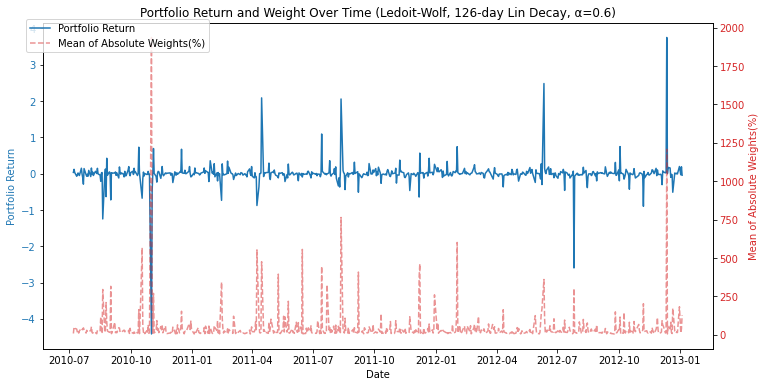

In [17]:
illustration_rets=stable_fullsample_analytical_returns_cache[(126, 'Lin', '0.2', 'LedoitWolf', '0.6')]
illustration_rets.index=pd.to_datetime(illustration_rets.index)

illustration_ws=stable_fullsample_analytical_weights_cache[(126, 'Lin', '0.2', 'LedoitWolf', '0.6')].abs().mean(axis=1)
illustration_ws.index=pd.to_datetime(illustration_ws.index)
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 6))

# y1：portfolio return
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Portfolio Return', color=color)
ax1.plot(illustration_rets.index, illustration_rets.values, color=color, label='Portfolio Return')
ax1.tick_params(axis='y', labelcolor=color)

# y2：abs sum of weights
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Mean of Absolute Weights(%)', color=color)
ax2.plot(illustration_ws.index, illustration_ws.values*100, color=color, linestyle='--', label='Mean of Absolute Weights(%)',alpha=0.5)
ax2.tick_params(axis='y', labelcolor=color)

fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

plt.title('Portfolio Return and Weight Over Time (Ledoit-Wolf, 126-day Lin Decay, α=0.6)')
plt.show()

In [18]:
# Group the DataFrame by 'lbw', 'decay_function', and 'decay_parameter', excluding rows where cov_estimator is 'GerberCov'
# Compute the mean of 'strategy_variance' for each group, then take the square root and scale to percentage terms
stable_fullsample_analytical_var_groupby_lbwNdecay = np.sqrt(
    stable_fullsample_analytical_var_df[stable_fullsample_analytical_var_df.cov_estimator != 'GerberCov']
    .groupby(['lbw', 'decay_function', 'decay_parameter'])['strategy_variance'].mean()
) * 100

# Round the results to 2 decimal places
stable_fullsample_analytical_var_groupby_lbwNdecay = stable_fullsample_analytical_var_groupby_lbwNdecay.round(2)

# Rename the Series to 'portfolio std'
stable_fullsample_analytical_var_groupby_lbwNdecay.name = 'portfolio std'

# Convert the values to string format and append a '%' symbol
stable_fullsample_analytical_var_groupby_lbwNdecay = stable_fullsample_analytical_var_groupby_lbwNdecay.astype(str) + '%'

# Display the final grouped result
display(stable_fullsample_analytical_var_groupby_lbwNdecay)

# Optionally save the result to CSV (commented out here)
# stable_fullsample_analytical_var_groupby_lbwNdecay.to_csv('for_report/stable_fullsample_analytical_var_groupby_lbwNdecay.csv')


lbw  decay_function  decay_parameter
21   EW              no param             47.5%
     Exp             0.97                24.24%
                     0.99                52.42%
     Lin             0.2                 36.11%
                     0.5                  83.3%
                     0.8                 33.13%
63   EW              no param           264.12%
     Exp             0.97               230.75%
                     0.99                32.63%
     Lin             0.2                558.18%
                     0.5                395.25%
                     0.8                698.06%
126  EW              no param            57.25%
     Exp             0.97               155.54%
                     0.99               143.67%
     Lin             0.2                229.01%
                     0.5                 113.0%
                     0.8                 50.62%
Name: portfolio std, dtype: object

### Analytical solution (stablized, reduced sample)

In [19]:
stable_reducedsample_analytical_var_df[stable_reducedsample_analytical_var_df.decay_function=='EW'].sort_values(by='strategy_variance').head(20)

,lbw,decay_function,decay_parameter,cov_estimator,cov_param,strategy_variance
102,126,EW,no param,LedoitWolf,0.6,0.000107
96,126,EW,no param,LedoitWolf,0.4,0.000107
90,126,EW,no param,LedoitWolf,0.2,0.000107
84,126,EW,no param,SCM,no param,0.000107
60,63,EW,no param,LedoitWolf,0.6,0.000129
54,63,EW,no param,LedoitWolf,0.4,0.000129
48,63,EW,no param,LedoitWolf,0.2,0.000129
42,63,EW,no param,SCM,no param,0.000129
0,21,EW,no param,SCM,no param,0.000371
18,21,EW,no param,LedoitWolf,0.6,0.000372


In [21]:
filter_condition=(stable_reducedsample_analytical_var_df.decay_function=='EW')

reducedsamle_analytical_estimators_comparison=stable_reducedsample_analytical_var_df[filter_condition].sort_values(by='strategy_variance').reset_index(drop=True)

reducedsamle_analytical_estimators_comparison['portfolio_std']=(np.sqrt(reducedsamle_analytical_estimators_comparison['strategy_variance'])*100).round(2)

reducedsamle_analytical_estimators_comparison['portfolio_std']=reducedsamle_analytical_estimators_comparison['portfolio_std'].astype(str)+'%'

reducedsamle_analytical_estimators_comparison.drop(columns=['decay_parameter','strategy_variance'],inplace=True)

display(reducedsamle_analytical_estimators_comparison)

# reducedsamle_analytical_estimators_comparison.to_csv('for_report/reducedsamle_analytical_estimators_comparison.csv',index=False)

,lbw,decay_function,cov_estimator,cov_param,portfolio_std
0,126,EW,LedoitWolf,0.6,1.04%
1,126,EW,LedoitWolf,0.4,1.04%
2,126,EW,LedoitWolf,0.2,1.04%
3,126,EW,SCM,no param,1.04%
4,63,EW,LedoitWolf,0.6,1.14%
5,63,EW,LedoitWolf,0.4,1.14%
6,63,EW,LedoitWolf,0.2,1.14%
7,63,EW,SCM,no param,1.14%
8,21,EW,SCM,no param,1.93%
9,21,EW,LedoitWolf,0.6,1.93%


In [22]:
sp500_train[stock_sublist].mean(axis=1).std()

0.012727029351999184

In [24]:
stable_reducedsample_analytical_var_groupby_lbwNdecay=np.sqrt(stable_reducedsample_analytical_var_df[stable_reducedsample_analytical_var_df.cov_estimator!='GerberCov'].groupby(['lbw','decay_function','decay_parameter'])['strategy_variance'].mean())*100

stable_reducedsample_analytical_var_groupby_lbwNdecay=stable_reducedsample_analytical_var_groupby_lbwNdecay.round(2)

stable_reducedsample_analytical_var_groupby_lbwNdecay.name='portfolio std'

stable_reducedsample_analytical_var_groupby_lbwNdecay=stable_reducedsample_analytical_var_groupby_lbwNdecay.astype(str)+'%'

display(stable_reducedsample_analytical_var_groupby_lbwNdecay)
# stable_reducedsample_analytical_var_groupby_lbwNdecay.to_csv('for_report/stable_reducedsample_analytical_var_groupby_lbwNdecay.csv')



lbw  decay_function  decay_parameter
21   EW              no param           1.93%
     Exp             0.97               1.93%
                     0.99               1.93%
     Lin             0.2                1.97%
                     0.5                1.93%
                     0.8                1.93%
63   EW              no param           1.14%
     Exp             0.97               1.18%
                     0.99               1.14%
     Lin             0.2                1.17%
                     0.5                1.15%
                     0.8                1.14%
126  EW              no param           1.04%
     Exp             0.97                1.1%
                     0.99               1.05%
     Lin             0.2                1.05%
                     0.5                1.04%
                     0.8                1.04%
Name: portfolio std, dtype: object

#### lbw

In [25]:
lbw_compare=feature_compare(stable_reducedsample_analytical_var_df[stable_reducedsample_analytical_var_df.decay_function=='EW'],'lbw')

print(lbw_compare['wins_count'])
lbw_compare['pivot_df']

126    6
21     1
Name: count, dtype: int64


lbw                                                          21   ...        126
decay_function decay_parameter cov_estimator cov_param            ...           
EW             no param        GerberCov     0.3        0.052834  ...   0.038004
                                             0.5        1.027024  ...   0.089644
                                             0.7        0.118537  ...  25.548192
                               LedoitWolf    0.2        0.000372  ...   0.000107
                                             0.4        0.000372  ...   0.000107
                                             0.6        0.000372  ...   0.000107
                               SCM           no param   0.000371  ...   0.000107

[7 rows x 3 columns]

In [26]:
lbw_compare['pivot_df'].describe()

lbw,21,63,126
count,7.000000,7.000000,7.000000
mean,0.171412,1.192733,3.668038
std,0.379901,3.026149,9.648299
min,0.000371,0.000129,0.000107
25%,0.000372,0.000129,0.000107
50%,0.000372,0.000129,0.000107
75%,0.085685,0.147515,0.063824
max,1.027024,8.053584,25.548192


#### cov estimator

In [27]:
cov_estimator_compare=feature_compare(
    stable_reducedsample_analytical_var_df[stable_reducedsample_analytical_var_df.decay_function=='EW'].groupby(['lbw', 'decay_function', 'decay_parameter', 'cov_estimator']).strategy_variance.mean().reset_index(),
    'cov_estimator'
)
print(cov_estimator_compare['wins_count'])
cov_estimator_compare['pivot_df']

LedoitWolf    2
SCM           1
Name: count, dtype: int64


,,cov_estimator,GerberCov,LedoitWolf,SCM
lbw,decay_function,decay_parameter,,,
21,EW,no param,0.399465,0.000372,0.000371
63,EW,no param,2.782872,0.000129,0.000129
126,EW,no param,8.558613,0.000107,0.000107


although LedoitWolf "wins" for 66.7% of the times, there's no significance in the realized variance of portfolio. In practice, for low dimensional problem, one might just simply use SCM.

#### Decay Functions

In [28]:
decay_functions_compare=feature_compare(
    stable_reducedsample_analytical_var_df.groupby(['lbw', 'decay_function', 'cov_estimator','cov_param']).strategy_variance.min().reset_index(),
    'decay_function'
)
print(decay_functions_compare['wins_count'])
decay_functions_compare['pivot_df'].describe()

EW     10
Exp     6
Lin     5
Name: count, dtype: int64

decay_function,EW,Exp,Lin
count,21.000000,21.000000,21.000000
mean,1.677394,0.296518,0.121900
std,5.742857,0.892893,0.367041
min,0.000107,0.000109,0.000108
25%,0.000129,0.000131,0.000129
50%,0.000372,0.000372,0.000372
75%,0.118537,0.109915,0.062774
max,25.548192,4.094150,1.679265


In [29]:
decay_functions_compare=feature_compare(
    stable_reducedsample_analytical_var_df.groupby(['lbw', 'decay_function', 'cov_estimator','cov_param']).strategy_variance.mean().reset_index(),
    'decay_function'
)
print(decay_functions_compare['wins_count'])
decay_functions_compare['pivot_df'].describe()

EW     15
Exp     5
Lin     1
Name: count, dtype: int64


decay_function,EW,Exp,Lin
count,21.000000,21.000000,21.000000
mean,1.677394,19.480320,20.061513
std,5.742857,85.383764,62.522086
min,0.000107,0.000115,0.000108
25%,0.000129,0.000135,0.000132
50%,0.000372,0.000372,0.000377
75%,0.118537,0.609028,0.646214
max,25.548192,391.998275,246.885337


no significant advantage of decaying